# Analyze A/B Test Results 

This project covers statistics. The notebook originates as a submission, and follows a set of instructions and prompts from the examiner, organized into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project seeks to understand the results of an A/B test run by an e-commerce website.  The aim is to help the company understand if they should:
- Implement the new webpage,
- Keep the old webpage, or
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [74]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [75]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [76]:
df.shape

(294478, 5)

<span style="color: blue;">There are 294478 rows in the dataset</span>.

**c.** The number of unique users in the dataset.

In [77]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

<span style="color: blue;">There are 290584 unique user_id entries in the dataset</span>.

**d.** The proportion of users converted.

In [78]:
df['converted'].value_counts(normalize='true')

converted
0    0.880341
1    0.119659
Name: proportion, dtype: float64

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [79]:
df.query('group=="treatment" and landing_page!="new_page"').shape

(1965, 5)

<span style="color: blue;">The number of times when the "group" is treatment but "landing_page" is not a new_page = 1965</span>.

**f.** Do any of the rows have missing values?

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


<span style="color: blue;">All the columns have 294478 non-null entries and so there are no rows with missing values</span>.

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [81]:
# Remove the inaccurate rows, and store the result in a new dataframe df2.
df.groupby('group')['landing_page'].value_counts()

group      landing_page
control    old_page        145274
           new_page          1928
treatment  new_page        145311
           old_page          1965
Name: count, dtype: int64

<span style="color: blue;">The previous cell shows a summary of the df. I will now collate the "error" data into a single df called df_error</span>.

In [82]:
df_error = df.query('group=="control" and landing_page=="new_page"')

In [83]:
df_error = pd.concat([df_error, df.query('group=="treatment" and landing_page=="old_page"')])

In [84]:
df_error.shape

(3893, 5)

<span style="color: blue;">I will now create df2 by removing the df_error entries from the original df. This is done using concat first, and then drop duplicates with keep = False</span>.

In [85]:
df2 = pd.concat([df, df_error]).drop_duplicates(keep=False)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [86]:
df2.shape

(290585, 5)

<span style="color: blue;">The number of rows look as I would expect now that the error items have been removed</span>.

In [87]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

<span style="color: blue;">Check provides 0. All good.</span>

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [88]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

<span style="color: blue;">There are 290584 unique user_id entries in df2</span>.

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [89]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


<span style="color: blue;">The user_id that is duplicated in df2 is 773192</span>.

**c.** Display the rows for the duplicate **user_id**? 

In [90]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [91]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
# Check again if the row with a duplicate user_id is deleted or not
df2 = df2.drop_duplicates(['user_id'])

In [92]:
df2.shape

(290584, 5)

In [93]:
# check no more duplicates in user_id
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted


<span style="color: blue;">There are no other duplicates in user_id in df2</span>.

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.

In [94]:
p_pop=df2[df2['converted']==1].shape[0] / df2.shape[0]
p_pop

0.11959708724499628

<span style="color: blue;">P_population (p_pop) is 0.119597</span>.

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [95]:
p_pop_con=df2.query('group=="control" and converted==1').shape[0] / df2[df2['group']=='control'].shape[0]
p_pop_con

0.1203863045004612

<span style="color: blue;">P_population_control (p_pop_con) is 0.1203863</span>.

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [96]:
p_pop_tre=df2.query('group=="treatment" and converted==1').shape[0] / df2[df2['group']=='treatment'].shape[0]
p_pop_tre

0.11880806551510564

<span style="color: blue;">P_population_treatment (p_pop_tre) is 0.11880806</span>.

In [97]:
# quick check to see if those results make sense
df2.groupby('group')['converted'].value_counts()

group      converted
control    0            127785
           1             17489
treatment  0            128046
           1             17264
Name: count, dtype: int64

<span style="color: blue;">Proportions look about right</span>.

>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [98]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_pop_tre - p_pop_con
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [99]:
p_new_page=df2[df2['landing_page']=='new_page'].shape[0] / df2.shape[0]
p_new_page

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

**Answer:** <span style="color: blue;">The probability difference between treatment group and control group converting is 0.16% more on the control group. This is not biased by the frequency receiving etiher page as the prob of either page is 50%. Thereofre, the results are neither statistically nor practically significant.</span>

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

**Put your answer here.** 

<center>
    $H_0$: $p_{old}$ > $p_{new}$<br>
    $H_1$: $p_{old}$ ≤ $p_{new}$<br>
    


### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [100]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [101]:
p_old = p_new
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [102]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [103]:
n_old = len(df2.query('group == "control"'))
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [104]:
# Simulate a Sample for the treatment Group
tests = np.random.choice([0,1],size=n_new,replace=True,p=[1-p_new,p_new])

# proportion of tests that produced conversion
p_new_sim = (tests==1).mean()
p_new_sim

0.12056293441607598

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [105]:
# Simulate a Sample for the control Group
tests = np.random.choice([0,1],size=n_old,replace=True,p=[1-p_old,p_old])

# proportion of tests that produced conversion
p_old_sim = (tests==1).mean()
p_old_sim

0.12002147665790162

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [106]:
p_new_sim - p_old_sim

0.0005414577581743518


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [107]:
# Sampling distribution 
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.

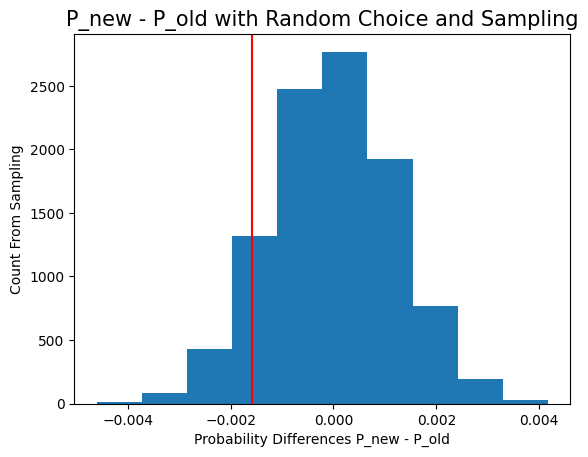

In [108]:
p_diffs = np.array(p_diffs);
plt.hist(p_diffs);
plt.axvline(obs_diff,c='red');
plt.title('P_new - P_old with Random Choice and Sampling', fontsize=15);
plt.xlabel('Probability Differences P_new - P_old');
plt.ylabel('Count From Sampling');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [109]:
# Compute p-value
(p_diffs > obs_diff).mean()

0.9006

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)".

**Answer:**
<span style="color: blue;">I computed the observed difference first.
I simulated the sampling distribution for the difference using random choice and then random binomial to show a quicker approach.
I computed a p-value of around 0.9 by finding the proportion of values in the distribution greater than our observed difference.
I can use this p-value to determine the statistical significance of our observed difference.
The p_value is much greater than the Type I error rate of 0.05, and therefore we fail to reject the null hypothesis.</span>



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [110]:
# number of conversions with the old_page
convert_old = sum(df2.query("group == 'control'")['converted'])
convert_old

17489

In [111]:
# number of conversions with the new_page
convert_new = sum(df2.query("group == 'treatment'")['converted'])
convert_new

17264

In [112]:
# number of individuals who were shown the old_page
n_old

145274

In [113]:
# number of individuals who received new_page
n_new

145310

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [114]:
import statsmodels.api as sm
# Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

**Answer:**
<span style="color: blue;"> For the one-sided t-test performed there we want to take an equal conversion rate under the null regardless of whether the user was shown the new page or the old page, hence we must take the mean of conversion of all rows of the modified dataframe df2. To perform this as right-tailed one-sided t-test we must set convert_new and n_new as the first parameters in the count and nobs, and then set the alternative to larger. The p-value is approximately 0.9, which is similar to our previous value of 0.9, and it stil greater than a Type I error rate of 0.05, and therefore, we again fail to reject the null hypothesis. As this is a right tailed test, we should reject null if 𝑍𝑠𝑐𝑜𝑟𝑒 >  𝑍𝛼. As this is a one-tailed test, our 𝑍𝛼 (𝑍0.05) = 1.645, as provided above, and so 𝑍𝑠𝑐𝑜𝑟𝑒 is < Z0.05, and so we fail to reject the null hypothesis.</span>

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**
<span style="color: blue;">
Logistic regression, because we are looking at categorical, boolean results. Whereas quantities in the form of floats would be suitable to linear regression or multiple linear regression.</span>

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [115]:
df2 = df2.join(pd.get_dummies(df2['group']))
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,control,treatment,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,True,False,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,True,False,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,True,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,True,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,True,False,1


In [116]:
df2 = df2.rename({'treatment': 'ab_page'}, axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,True,False,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,True,False,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,True,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,True,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,True,False,1


In [117]:
# Convert 'ab_page' true/false values to binary
df2['ab_page'] = df2['ab_page'].astype(int)
df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,True,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,True,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,True,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [118]:
lm = sm.Logit(df2['converted'], df2[['intercept','ab_page']])

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [119]:
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-08-28 19:09 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.18988    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [120]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [121]:
1/_

intercept    7.306593
ab_page      1.015102
dtype: float64

**e.** What is the p-value associated with **ab_page**? 

Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


**Answer:**
<span style="color: blue;">
The null hypotheses are that there is no affect on the converted value from the ab_page. The alternative hypothesis is that there is a relationship between 'ab_page' and 'converted. The p-value from the above regresion for 'ab_page' is 0.1899 which is greater than the Type I error rate of 0.05 and so we fail to reject the null hypothesis. Part III uses a two-tail (two-sided) hypothesis test, whereas part II was a one-tailed (right-sided) z-test.</span>

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**
<span style="color: blue;">One of the problems that could arise by considering other additional factors may be multicollinearity.</span>

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns.

 Provide the statistical output as well as a written response to answer this question.

In [122]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [123]:
df_countries.shape

(290584, 2)

In [124]:
df2.shape

(290584, 8)

In [125]:
df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,True,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,True,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,True,0,1


In [126]:
df_countries = df_countries.sort_values(by=['user_id'])

In [127]:
df2 = df2.sort_values(by=['user_id'])

In [128]:
# Join with the df2 dataframe
df_merged = df2.join(df_countries['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept,country
63114,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,False,1,1,US
103873,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,False,1,1,US
205236,630002,2017-01-19 19:20:56.438330,control,old_page,0,True,0,1,US
247344,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,False,1,1,US
242283,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,False,1,1,US


In [129]:
# Create the necessary dummy variables
df_merged = df_merged.join(pd.get_dummies(df_merged['country']))
# Create binary values
df_merged['CA'] = df_merged['CA'].astype(int)
df_merged['UK'] = df_merged['UK'].astype(int)
df_merged['US'] = df_merged['US'].astype(int)
df_merged.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept,country,CA,UK,US
63114,630000,2017-01-19 06:26:06.548941,treatment,new_page,0,False,1,1,US,0,0,1
103873,630001,2017-01-16 03:16:42.560309,treatment,new_page,1,False,1,1,US,0,0,1
205236,630002,2017-01-19 19:20:56.438330,control,old_page,0,True,0,1,US,0,0,1
247344,630003,2017-01-12 10:09:31.510471,treatment,new_page,0,False,1,1,US,0,0,1
242283,630004,2017-01-18 20:23:58.824994,treatment,new_page,0,False,1,1,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [130]:
# Fit your model, and summarize the results
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']

df_merged['intercept'] = 1
lm = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','UK','US','UK_ab_page','US_ab_page']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-08-28 19:09 AIC:              212784.1015
No. Observations:   290584           BIC:              212847.5794
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.30942    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0497    0.0331  -61.9451  0.0000  -2.1145  -1.9848
ab_page        0.0589    0.0462    1.2755  0.2021  -0.0316   0.1494
UK             0.0651    0.0368    1.7666  0.0773  -0.0071   0.1373
US             0.0647    0.0345    1.8777  0.0604  -0.0028   0.1323
UK_ab_page    -0.0699    0.0516   -1.3554  0.1753  -0.1710   0.0312
US_ab_page    -0.0818    0.0482   -1.6981  0.0895  -0.1762   0.0126
==================================================================

"""

In [131]:
np.exp(results.params)

intercept     0.128778
ab_page       1.060661
UK            1.067228
US            1.066881
UK_ab_page    0.932472
US_ab_page    0.921447
dtype: float64

In [132]:
1/_

intercept     7.765276
ab_page       0.942808
UK            0.937007
US            0.937312
UK_ab_page    1.072419
US_ab_page    1.085249
dtype: float64

**Conclusion:**
<span style="color: blue;">
<br>
<br>
UK p-value is 0.0773, greater than Type I error rate of 0.05.<br>
US p-value is 0.0604, greater than Type I error rate of 0.05.<br>
UK_ab_page p-value is 0.1753, greater than Type I error rate of 0.05.<br>
US ab_page p-value is 0.0895, greater than Type I error rate of 0.05.<br>
<br>
Fail to reject null hypothesis.<br>
<br>
These results are statistically significant, but not practically significant.</span>